In [2]:
import fastf1
from fastf1 import logger
fastf1.ergast.interface.BASE_URL = "https://api.jolpi.ca/ergast/f1" # type: ignore
# logger.set_log_level('ERROR')
import pandas as pd
import numpy as np
import time
from typing import Callable, Any
from functools import wraps
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
def track_time(func: Callable) -> Callable:
    @wraps(func)
    def wrapper(*args: Any, **kwargs: Any) -> Any:
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        print(f"{func.__name__} executed in {end - start:.4f} seconds")
        return result
    return wrapper

In [4]:
@track_time
def add_weather_info(session, stints_df):
    #TODO: Segmentar clima por stint
    """
    Adds mean weather information from the session to the stints dataframe
    
    Args:
        session: FastF1 session object containing weather data
        stints_df: DataFrame containing stint data
        
    Returns:
        DataFrame with added weather columns
    """
    # Get weather data from session
    weather = session.weather_data
    
    # Calculate mean values
    mean_weather = weather.mean()
    
    # Add weather columns with broadcast values
    for col in mean_weather.index:
        stints_df[col] = mean_weather[col]
        
    return stints_df

@track_time
def add_starting_positions(session, stints_df):
    """
    Adds starting grid position for each driver in the stints dataframe
    
    Args:
        session: FastF1 session object containing grid position info
        stints_df: DataFrame containing stint data
        
    Returns:
        DataFrame with added StartingPosition column
    """
    # Get starting grid positions
    grid = session.results[['Abbreviation', 'GridPosition']]
    grid = grid.set_index('Abbreviation')
    grid_dict = grid['GridPosition'].to_dict()
    
    # Add starting position column based on driver
    stints_df['StartingPosition'] = stints_df['Driver'].map(grid_dict)
    
    return stints_df

@track_time
def add_team_info(session, stints_df):
    """
    Adds team information for each driver in the stints dataframe
    
    Args:
        session: FastF1 session object containing driver info
        stints_df: DataFrame containing stint data
        
    Returns:
        DataFrame with added Team column
    """
    # Create driver to team mapping
    driver_teams = {}
    for driver in session.drivers:
        driver_info = session.get_driver(driver)
        driver_teams[driver_info['Abbreviation']] = driver_info['TeamName']
    
    # Add team column based on driver
    stints_df['Team'] = stints_df['Driver'].map(driver_teams)
    
    return stints_df

@track_time
def get_stints_race(session):
    laps = session.laps
    drivers = session.drivers
    drivers = [session.get_driver(driver)["Abbreviation"] for driver in drivers]
    stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
    stints = stints.groupby(["Driver", "Stint", "Compound"])
    stints = stints.count().reset_index()
    stints = stints.rename(columns={"LapNumber": "StintLength"})
    return stints


In [5]:
def process_lap(lap):
    """
    Processes telemetry for a single lap to calculate performance metrics.

    Args:
        lap: A FastF1 Lap object.

    Returns:
        A dictionary with calculated metrics for the lap, or None on failure.
    """
    try:
        # get_telemetry() loads data on-demand for this specific lap
        telemetry = lap.get_telemetry().copy()

        required_cols = ['Time', 'Brake', 'Speed', 'nGear']
        if telemetry.empty or not all(col in telemetry.columns for col in required_cols):
            return None

        # Calculate time delta between telemetry points for accurate duration calculation
        telemetry['TimeDelta'] = telemetry['Time'].diff().dt.total_seconds()
        
        # Calculate total time braking during the lap
        total_braking_time = telemetry.loc[telemetry['Brake'] == True, 'TimeDelta'].sum()

        # Calculate speed and gear-related metrics
        avg_speed = telemetry['Speed'].mean()
        speed_delta = telemetry['Speed'].max() - telemetry['Speed'].min()
        gear_changes = telemetry['nGear'].diff().ne(0).sum()
        
        return {
            'brake_duration': total_braking_time if total_braking_time > 0 else np.nan,
            'avg_speed': avg_speed,
            'speed_delta': speed_delta,
            'gear_changes': gear_changes
        }
    except Exception as e:
        # Log errors for individual laps without stopping the entire process
        print(f"Could not process Lap {lap.LapNumber} for Driver {lap.Driver}. Error: {e}")
        return None


def process_stint(session, driver, stint_number):
    """
    Worker function to process telemetry for a single stint sequentially.
    
    It iterates through all laps for a given stint, processes them one by one,
    and aggregates the results.

    Returns:
        A dictionary containing the driver, stint number, and aggregated metrics.
        Returns None if processing fails.
    """
    try:
        # A more efficient way to select laps for a specific driver and stint
        stint_laps = session.laps.pick_drivers([driver])
        stint_laps = stint_laps[stint_laps["Stint"] == stint_number]

        if stint_laps.empty:
            return None

        laps_to_process = [lap for _, lap in stint_laps.iterlaps()]

        if not laps_to_process:
            return None

        # --- Sequential Lap Processing ---
        valid_results = []
        for lap in laps_to_process:
            lap_result = process_lap(lap)
            if lap_result:
                valid_results.append(lap_result)
        
        # --- Aggregation ---
        if not valid_results:
            return None

        # Unpack the list of dictionaries into separate lists for aggregation
        lap_brake_durations = [r['brake_duration'] for r in valid_results if not np.isnan(r['brake_duration'])]
        lap_avg_speeds = [r['avg_speed'] for r in valid_results]
        lap_speed_deltas = [r['speed_delta'] for r in valid_results]
        lap_gear_changes = [r['gear_changes'] for r in valid_results]

        # Aggregate the per-lap metrics into stint-level statistics
        results = {
            'Driver': driver,
            'Stint': stint_number,
            'mean_brake_time': np.mean(lap_brake_durations) if lap_brake_durations else np.nan,
            'std_brake_time': np.std(lap_brake_durations) if lap_brake_durations else np.nan,
            'AvgSpeed': np.mean(lap_avg_speeds) if lap_avg_speeds else np.nan,
            'StdSpeed': np.std(lap_avg_speeds) if lap_avg_speeds else np.nan,
            'AvgSpeedDelta': np.mean(lap_speed_deltas) if lap_speed_deltas else np.nan,
            'StdSpeedDelta': np.std(lap_speed_deltas) if lap_speed_deltas else np.nan,
            'AvgGearChanges': np.mean(lap_gear_changes) if lap_gear_changes else np.nan,
        }
        return results

    except Exception as e:
        print(f"Could not process Stint {stint_number} for {driver}. Error: {e}")
        return None

@track_time
def add_stint_telemetry(session, stints_df):
    """
    Adds telemetry-derived metrics to a stints DataFrame by processing each
    stint and its laps sequentially.

    Args:
        session: A loaded FastF1 session object.
        stints_df: A pandas DataFrame with 'Driver' and 'Stint' columns.

    Returns:
        pandas.DataFrame: The original stints_df with new columns for telemetry.
    """
    if not hasattr(session.laps, 'iloc'):
        session.load(laps=True, telemetry=True, weather=False, messages=False)
    
    results = []
    # This loop iterates through all stints sequentially and displays a single progress bar.
    for _, stint in tqdm(list(stints_df.iterrows()), desc="Processing all stints"):
        driver = stint['Driver']
        stint_number = stint['Stint']
        
        result = process_stint(session, driver, stint_number)
        
        if result:
            results.append(result)
            
    if not results:
        print("Warning: No stints were processed successfully.")
        return stints_df
        
    results_df = pd.DataFrame(results)

    # Merge the new telemetry metrics back into the original stints DataFrame
    stints_df = stints_df.merge(results_df, on=['Driver', 'Stint'], how='left')

    return stints_df

In [ ]:
for year in range(2019, 2024):
    # Get the calendar for the year
    calendar = fastf1.get_event_schedule(year, include_testing=False)
    
    # Initialize an empty list to store all stints data
    all_stints = []
    
    # Loop through each race in the calendar
    for idx, event in calendar.iterrows():
        try:
            # Load the race session
            session = fastf1.get_session(year, event['EventName'], 'R')
            session.load()
    
            # Get stints for this race
            race_stints = get_stints_race(session)
    
            # Add the team names for each row
            race_stints = add_team_info(session, race_stints)
    
            # Add the starting position for each driver
            race_stints = add_starting_positions(session, race_stints)
    
            # Add mean weather information
            race_stints = add_weather_info(session, race_stints)

            # Add telemetry information
            race_stints = add_stint_telemetry(session, race_stints)
            
            # Add year and circuit information
            race_stints['Year'] = year
            race_stints['Circuit'] = event['EventName']
    
            # Append to our list
            all_stints.append(race_stints)
    
            print(f"Processed {year} {event['EventName']}")
            # input()
        except Exception as e:
            print(f"Error processing {year} {event['EventName']}: {e}")
            # input()
    
    # If we have data for this year, concatenate it
    if all_stints:
        year_stints = pd.concat(all_stints, ignore_index=True)
    
        # Save the data for this year (optional)
        year_stints.to_csv(f"..\\data\\stints_data_{year}.csv", index=False)

In [6]:
stints_2019 = pd.read_csv("..\\data\\stints_data_2019.csv", index_col=None)
stints_2020 = pd.read_csv("..\\data\\stints_data_2020.csv", index_col=None)
stints_2021 = pd.read_csv("..\\data\\stints_data_2021.csv", index_col=None)
stints_2022 = pd.read_csv("..\\data\\stints_data_2022.csv", index_col=None)
stints_2023 = pd.read_csv("..\\data\\stints_data_2023.csv", index_col=None)
stints_2024 = pd.read_csv("..\\data\\stints_data_2024.csv", index_col=None)

stints = pd.concat([stints_2019, stints_2020, stints_2021, stints_2022, stints_2023, stints_2024])
stints

,Driver,Stint,Compound,StintLength,Team,StartingPosition,Time,AirTemp,Humidity,Pressure,...,WindSpeed,mean_brake_time,std_brake_time,AvgSpeed,StdSpeed,AvgSpeedDelta,StdSpeedDelta,AvgGearChanges,Year,Circuit
0,ALB,1.0,SOFT,14,Toro Rosso,13.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,...,1.166393,16.848500,2.609767,204.453924,9.638613,228.785714,27.103449,46.500000,2019,Australian Grand Prix
1,ALB,2.0,MEDIUM,43,Toro Rosso,13.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,...,1.166393,15.366744,1.481661,210.861675,3.012902,223.076478,11.134140,44.883721,2019,Australian Grand Prix
2,BOT,1.0,SOFT,23,Mercedes,2.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,...,1.166393,12.160522,1.770602,212.393517,7.822535,218.826087,22.160780,40.173913,2019,Australian Grand Prix
3,BOT,2.0,MEDIUM,35,Mercedes,2.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,...,1.166393,12.335229,1.054448,216.793137,2.787934,213.477143,6.962104,39.457143,2019,Australian Grand Prix
4,GAS,1.0,MEDIUM,37,Red Bull Racing,17.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,...,1.166393,15.714432,2.424948,209.376996,7.382757,234.907883,18.758009,40.918919,2019,Australian Grand Prix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,VER,1.0,MEDIUM,29,Red Bull Racing,4.0,0 days 01:14:27.206128378,26.768243,51.445946,1017.426351,...,1.900676,16.066103,1.878458,205.419774,9.531109,259.655172,17.201195,39.620690,2024,Abu Dhabi Grand Prix
748,VER,2.0,HARD,29,Red Bull Racing,4.0,0 days 01:14:27.206128378,26.768243,51.445946,1017.426351,...,1.900676,14.707172,3.306982,210.731920,9.665738,258.206897,13.425091,40.034483,2024,Abu Dhabi Grand Prix
749,ZHO,1.0,MEDIUM,12,Kick Sauber,15.0,0 days 01:14:27.206128378,26.768243,51.445946,1017.426351,...,1.900676,18.329667,2.409446,200.108530,14.604467,262.083333,23.286113,45.833333,2024,Abu Dhabi Grand Prix
750,ZHO,2.0,HARD,27,Kick Sauber,15.0,0 days 01:14:27.206128378,26.768243,51.445946,1017.426351,...,1.900676,16.529074,1.627520,207.185117,7.696528,250.592593,13.073182,41.814815,2024,Abu Dhabi Grand Prix


In [6]:
#TODO: Investigar posição de largada 0
# stints['StartingPosition'] = stints['StartingPosition'].replace(0, np.nan)
problema_pos_larg = stints[stints['StartingPosition'] == 0]
problema_pos_larg

,Driver,Stint,Compound,StintLength,Team,StartingPosition,Time,AirTemp,Humidity,Pressure,...,WindSpeed,mean_brake_time,std_brake_time,AvgSpeed,StdSpeed,AvgSpeedDelta,StdSpeedDelta,AvgGearChanges,Year,Circuit
102,ALB,1.0,SOFT,19,Toro Rosso,0.0,0 days 01:03:37.041299212,19.329921,45.981102,1019.218110,...,3.315748,21.012895,4.020582,189.486898,11.306206,262.736842,13.540746,48.526316,2019,Chinese Grand Prix
103,ALB,2.0,HARD,36,Toro Rosso,0.0,0 days 01:03:37.041299212,19.329921,45.981102,1019.218110,...,3.315748,18.521444,1.388652,195.161511,5.065364,249.222222,13.383471,46.416667,2019,Chinese Grand Prix
163,GAS,1.0,MEDIUM,39,Red Bull Racing,0.0,0 days 01:04:46.987325581,19.763566,51.408527,1013.775194,...,1.249612,20.687744,3.126053,196.033586,15.300071,259.584722,17.102673,54.410256,2019,Azerbaijan Grand Prix
173,KUB,1.0,MEDIUM,14,Williams,0.0,0 days 01:04:46.987325581,19.763566,51.408527,1013.775194,...,1.249612,28.873786,3.603627,188.977901,8.321189,262.720833,18.956625,56.857143,2019,Azerbaijan Grand Prix
174,KUB,2.0,MEDIUM,9,Williams,0.0,0 days 01:04:46.987325581,19.763566,51.408527,1013.775194,...,1.249612,25.482333,1.640467,190.944903,6.397534,246.444444,2.793290,52.666667,2019,Azerbaijan Grand Prix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142,STR,1.0,MEDIUM,30,Aston Martin,0.0,0 days 01:35:23.203068421,25.547368,23.552632,779.520526,...,1.490000,21.758700,2.893212,176.005170,7.632044,277.733333,15.956051,37.133333,2023,Mexico City Grand Prix
1143,STR,2.0,HARD,4,Aston Martin,0.0,0 days 01:35:23.203068421,25.547368,23.552632,779.520526,...,1.490000,21.132500,5.154172,143.511207,20.781157,273.987500,32.642005,38.500000,2023,Mexico City Grand Prix
1144,STR,3.0,HARD,32,Aston Martin,0.0,0 days 01:35:23.203068421,25.547368,23.552632,779.520526,...,1.490000,20.574906,4.493900,175.835492,20.372772,285.250000,15.628500,39.312500,2023,Mexico City Grand Prix
552,OCO,1.0,HARD,48,Alpine,0.0,0 days 01:19:50.021056603,19.888679,51.050314,785.252830,...,2.150943,22.601667,2.031021,174.840210,21.588046,270.520833,18.132601,39.270833,2024,Mexico City Grand Prix


In [7]:
year, circuit = problema_pos_larg.iloc[2][['Year', 'Circuit']]
session = fastf1.get_session(year, circuit, 'R')
session.load()

req         WARNING 	DEFAULT CACHE ENABLED! (12.35 GB) C:\Users\rafam\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.075000 before the recorded end of the session.
core           INFO 	Finish

In [8]:
# session.laps.pick_drivers(['ALB']).columns
print("Session results columns:", session.results.columns, "\n")
print(session.results[['Abbreviation', 'GridPosition', 'ClassifiedPosition', 'Position']].sort_values(by='GridPosition'))
print("Session results:", session.results.head())

Session results columns: Index(['DriverNumber', 'BroadcastName', 'Abbreviation', 'DriverId', 'TeamName',
       'TeamColor', 'TeamId', 'FirstName', 'LastName', 'FullName',
       'HeadshotUrl', 'CountryCode', 'Position', 'ClassifiedPosition',
       'GridPosition', 'Q1', 'Q2', 'Q3', 'Time', 'Status', 'Points', 'Laps'],
      dtype='object') 

   Abbreviation  GridPosition ClassifiedPosition  Position
88          KUB           0.0                 16      16.0
7           RAI           0.0                 10      10.0
10          GAS           0.0                  R      17.0
77          BOT           1.0                  1       1.0
44          HAM           2.0                  2       2.0
5           VET           3.0                  3       3.0
33          VER           4.0                  4       4.0
11          PER           5.0                  6       6.0
26          KVY           6.0                  R      19.0
4           NOR           7.0                  8       8.0
16    

Algumas entradas possuem o valor 0 na coluna StartingPosition, mostrando que o piloto largou dos boxes. O motivo pode ser uma penalização ou pela troca de partes do carro sob o regime parc fermé.

Talvez seja interessantes trocar o valor 0 por 20 para relacionar a uma distancia maior do líder.

In [9]:

#TODO: Investigar desvio padrão = 0
stints[stints['StdSpeed'] == 0]['StintLength'].value_counts()
# Como não existiria variação em stints de uma volta, vamos remover esses stints da análise


StintLength
1     437
25      1
5       1
9       1
4       1
22      1
Name: count, dtype: int64

In [10]:
stints_std_prb = stints[(stints['StdSpeed'] == 0) & (stints['StintLength'] != 1)]
stints_std_prb

,Driver,Stint,Compound,StintLength,Team,StartingPosition,Time,AirTemp,Humidity,Pressure,...,WindSpeed,mean_brake_time,std_brake_time,AvgSpeed,StdSpeed,AvgSpeedDelta,StdSpeedDelta,AvgGearChanges,Year,Circuit
1,ALB,2.0,HARD,25,Red Bull Racing,4.0,0 days 01:04:38.184825,28.684167,33.832500,938.770833,...,1.887500,75.623240,14.593246,225.0,0.0,0.0,0.0,1.0,2020,Austrian Grand Prix
2,ALB,3.0,SOFT,5,Red Bull Racing,4.0,0 days 01:04:38.184825,28.684167,33.832500,938.770833,...,1.887500,108.480800,6.774046,225.0,0.0,0.0,0.0,1.0,2020,Austrian Grand Prix
3,ALB,4.0,SOFT,9,Red Bull Racing,4.0,0 days 01:04:38.184825,28.684167,33.832500,938.770833,...,1.887500,82.726889,25.148333,225.0,0.0,0.0,0.0,1.0,2020,Austrian Grand Prix
970,BOT,2.0,WET,4,Alfa Romeo,12.0,0 days 02:07:45.817513725,16.717647,86.211765,1015.706275,...,2.040784,164.410500,27.065209,0.0,0.0,0.0,0.0,1.0,2022,Japanese Grand Prix
971,BOT,3.0,INTERMEDIATE,22,Alfa Romeo,12.0,0 days 02:07:45.817513725,16.717647,86.211765,1015.706275,...,2.040784,111.298091,4.820095,0.0,0.0,0.0,0.0,1.0,2022,Japanese Grand Prix


In [ ]:
year, circuit = stints_std_prb.iloc[0][['Year', 'Circuit']]
session = fastf1.get_session(year, circuit, 'R')
session.load()

<Axes: xlabel='Time'>

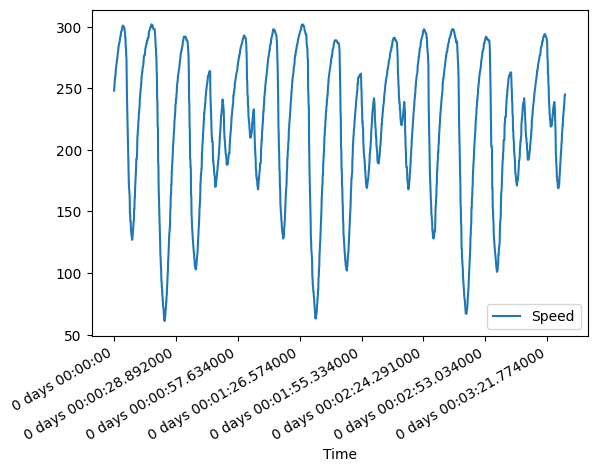

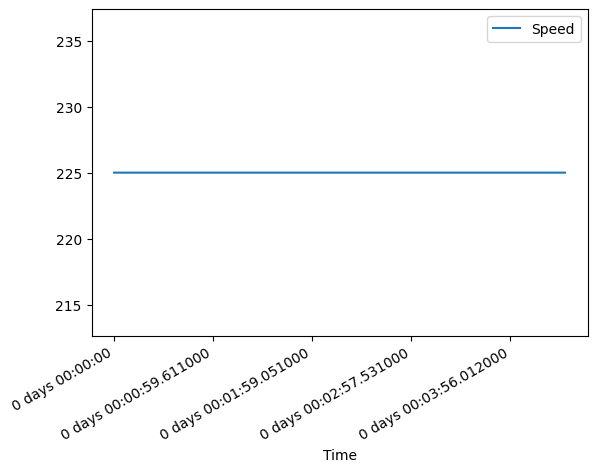

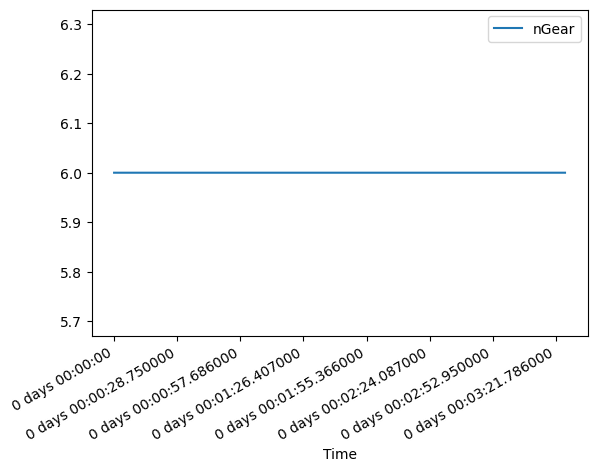

In [14]:
# Iterate through the laps of ALB
# for _, lap in session.laps.pick_drivers(['ALB']).iterlaps():
    # print(f"Lap {lap['LapNumber']} - Speed Mean: {lap.telemetry['Speed'].mean()}, Std: {lap.telemetry['Speed'].std()}")

session.laps.pick_drivers(['ALB']).pick_laps([10,11,12]).get_telemetry().plot(x='Time', y='Speed')
session.laps.pick_drivers(['ALB']).pick_laps([20,21,22]).get_telemetry().plot(x='Time', y='Speed')
session.laps.pick_drivers(['ALB']).pick_laps([30,31,32]).get_telemetry().plot(x='Time', y='nGear')


Por algum motivo, a telemetria de velocidade do albon ficou estagnada no valor 225 pelo resto da corrida. Isso provavelmente é um erro de leitura do sensor ou um erro de dados da própria fast f1 ou jolpica.

In [13]:
#TODO: Investigar telemetrias indisponíveis
stints_tel_missing = stints[stints['AvgSpeed'].isna() | stints['AvgSpeedDelta'].isna() | stints['AvgGearChanges'].isna() | stints['mean_brake_time'].isna() | stints['std_brake_time'].isna()]
stints_tel_missing

,Driver,Stint,Compound,StintLength,Team,StartingPosition,Time,AirTemp,Humidity,Pressure,...,WindSpeed,mean_brake_time,std_brake_time,AvgSpeed,StdSpeed,AvgSpeedDelta,StdSpeedDelta,AvgGearChanges,Year,Circuit
839,BOT,1.0,MEDIUM,49,Mercedes,1.0,0 days 01:03:25.834062992,20.947244,58.169291,1015.941732,...,1.948031,NaN,NaN,207.710976,24.553348,238.372449,16.372117,29.816327,2020,Sakhir Grand Prix
840,BOT,2.0,HARD,13,Mercedes,1.0,0 days 01:03:25.834062992,20.947244,58.169291,1015.941732,...,1.948031,NaN,NaN,208.801916,23.104591,243.923077,19.997929,31.538462,2020,Sakhir Grand Prix
841,BOT,3.0,HARD,25,Mercedes,1.0,0 days 01:03:25.834062992,20.947244,58.169291,1015.941732,...,1.948031,NaN,NaN,199.391530,35.245262,252.580000,30.109029,32.000000,2020,Sakhir Grand Prix
286,MAZ,1.0,SOFT,34,Haas F1 Team,19.0,0 days 01:07:25.500674074,20.760741,61.424444,1015.571111,...,0.316296,NaN,NaN,146.831619,6.422602,243.437990,9.178576,40.705882,2021,Monaco Grand Prix
287,MAZ,2.0,HARD,41,Haas F1 Team,19.0,0 days 01:07:25.500674074,20.760741,61.424444,1015.571111,...,0.316296,NaN,NaN,151.044822,3.876073,239.829268,3.035581,41.487805,2021,Monaco Grand Prix
913,STR,2.0,HARD,21,Aston Martin,12.0,0 days 01:13:35.473170068,27.734694,33.149660,993.340136,...,1.361224,NaN,NaN,232.061376,9.658933,265.380952,11.753322,39.190476,2022,Italian Grand Prix


In [42]:
stints_tel_0 = stints[stints['AvgSpeed'].isin([0]) | stints['AvgSpeedDelta'].isin([0]) | stints['AvgGearChanges'].isin([0]) | stints['mean_brake_time'].isin([0])]
stints_tel_0

,Driver,Stint,Compound,StintLength,Team,StartingPosition,Time,AirTemp,Humidity,Pressure,...,WindSpeed,mean_brake_time,std_brake_time,AvgSpeed,StdSpeed,AvgSpeedDelta,StdSpeedDelta,AvgGearChanges,Year,Circuit
1,ALB,2.0,HARD,25,Red Bull Racing,4.0,0 days 01:04:38.184825,28.684167,33.832500,938.770833,...,1.887500,75.623240,14.593246,225.0,0.0,0.0,0.0,1.0,2020,Austrian Grand Prix
2,ALB,3.0,SOFT,5,Red Bull Racing,4.0,0 days 01:04:38.184825,28.684167,33.832500,938.770833,...,1.887500,108.480800,6.774046,225.0,0.0,0.0,0.0,1.0,2020,Austrian Grand Prix
3,ALB,4.0,SOFT,9,Red Bull Racing,4.0,0 days 01:04:38.184825,28.684167,33.832500,938.770833,...,1.887500,82.726889,25.148333,225.0,0.0,0.0,0.0,1.0,2020,Austrian Grand Prix
178,HUL,1.0,HARD,1,Racing Point,13.0,0 days 01:03:53.647265625,21.291406,44.167969,998.408594,...,3.114063,94.171000,0.000000,0.0,0.0,0.0,0.0,1.0,2020,British Grand Prix
355,SAI,1.0,SOFT,1,McLaren,7.0,0 days 01:00:19.027842975,18.568595,54.852893,962.429752,...,1.465289,112.487000,0.000000,0.0,0.0,0.0,0.0,1.0,2020,Belgian Grand Prix
285,LEC,1.0,SOFT,1,Ferrari,1.0,0 days 01:07:25.500674074,20.760741,61.424444,1015.571111,...,0.316296,82.123000,0.000000,0.0,0.0,0.0,0.0,1.0,2021,Monaco Grand Prix
760,TSU,1.0,MEDIUM,1,AlphaTauri,0.0,0 days 01:14:07.741040268,28.885235,33.275839,994.487919,...,0.342953,97.798000,0.000000,0.0,0.0,0.0,0.0,1.0,2021,Italian Grand Prix
970,BOT,2.0,WET,4,Alfa Romeo,12.0,0 days 02:07:45.817513725,16.717647,86.211765,1015.706275,...,2.040784,164.410500,27.065209,0.0,0.0,0.0,0.0,1.0,2022,Japanese Grand Prix
971,BOT,3.0,INTERMEDIATE,22,Alfa Romeo,12.0,0 days 02:07:45.817513725,16.717647,86.211765,1015.706275,...,2.040784,111.298091,4.820095,0.0,0.0,0.0,0.0,1.0,2022,Japanese Grand Prix
855,TSU,1.0,MEDIUM,1,AlphaTauri,11.0,0 days 01:18:08.933269230,29.330128,42.320513,1000.561538,...,1.139744,87.266000,0.000000,0.0,0.0,0.0,0.0,1.0,2023,Italian Grand Prix


In [18]:
year, circuit = stints_tel_missing.iloc[0][['Year', 'Circuit']]
session = fastf1.get_session(year, circuit, 'R')
session.load()

events      WARNING 	Correcting user input 'Sakhir Grand Prix' to 'Sakhir Grand Prix'
core           INFO 	Loading data for Sakhir Grand Prix - Race [v3.6.0]
core           INFO 	Loading data for Sakhir Grand Prix - Race [v3.6.0]


req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for car_data
req            INFO 	Using cached 

In [19]:
process_stint(session, 'BOT', 1)

{'Driver': 'BOT',
 'Stint': 1,
 'mean_brake_time': nan,
 'std_brake_time': nan,
 'AvgSpeed': np.float64(207.71097574614708),
 'StdSpeed': np.float64(24.553348287246322),
 'AvgSpeedDelta': np.float64(238.37244891428574),
 'StdSpeedDelta': np.float64(16.37211748719178),
 'AvgGearChanges': np.float64(29.816326530612244)}

In [27]:
session.laps.pick_drivers(['BOT']).get_telemetry()['Brake'].value_counts()

Brake
False    47324
Name: count, dtype: int64

Assim, se as colunas de tempo médio de frenagem e desvio padrão do tempo de frenagem estiverem vazias, é sinal que a telemetria do piloto apenas tem valores falsos ou nulos.

In [15]:
#TODO: Investigar número de trocas de marcha muito baixos
stints_gear_changes = stints[stints['AvgGearChanges'] < 5]# .sort_values(by=['StintLength', 'AvgGearChanges'], ascending=[False, True])
stints_gear_changes

,Driver,Stint,Compound,StintLength,Team,StartingPosition,Time,AirTemp,Humidity,Pressure,...,WindSpeed,mean_brake_time,std_brake_time,AvgSpeed,StdSpeed,AvgSpeedDelta,StdSpeedDelta,AvgGearChanges,Year,Circuit
1,ALB,2.0,HARD,25,Red Bull Racing,4.0,0 days 01:04:38.184825,28.684167,33.832500,938.770833,...,1.887500,75.623240,14.593246,225.0,0.0,0.0,0.0,1.0,2020,Austrian Grand Prix
2,ALB,3.0,SOFT,5,Red Bull Racing,4.0,0 days 01:04:38.184825,28.684167,33.832500,938.770833,...,1.887500,108.480800,6.774046,225.0,0.0,0.0,0.0,1.0,2020,Austrian Grand Prix
3,ALB,4.0,SOFT,9,Red Bull Racing,4.0,0 days 01:04:38.184825,28.684167,33.832500,938.770833,...,1.887500,82.726889,25.148333,225.0,0.0,0.0,0.0,1.0,2020,Austrian Grand Prix
178,HUL,1.0,HARD,1,Racing Point,13.0,0 days 01:03:53.647265625,21.291406,44.167969,998.408594,...,3.114063,94.171000,0.000000,0.0,0.0,0.0,0.0,1.0,2020,British Grand Prix
355,SAI,1.0,SOFT,1,McLaren,7.0,0 days 01:00:19.027842975,18.568595,54.852893,962.429752,...,1.465289,112.487000,0.000000,0.0,0.0,0.0,0.0,1.0,2020,Belgian Grand Prix
285,LEC,1.0,SOFT,1,Ferrari,1.0,0 days 01:07:25.500674074,20.760741,61.424444,1015.571111,...,0.316296,82.123000,0.000000,0.0,0.0,0.0,0.0,1.0,2021,Monaco Grand Prix
760,TSU,1.0,MEDIUM,1,AlphaTauri,0.0,0 days 01:14:07.741040268,28.885235,33.275839,994.487919,...,0.342953,97.798000,0.000000,0.0,0.0,0.0,0.0,1.0,2021,Italian Grand Prix
970,BOT,2.0,WET,4,Alfa Romeo,12.0,0 days 02:07:45.817513725,16.717647,86.211765,1015.706275,...,2.040784,164.410500,27.065209,0.0,0.0,0.0,0.0,1.0,2022,Japanese Grand Prix
971,BOT,3.0,INTERMEDIATE,22,Alfa Romeo,12.0,0 days 02:07:45.817513725,16.717647,86.211765,1015.706275,...,2.040784,111.298091,4.820095,0.0,0.0,0.0,0.0,1.0,2022,Japanese Grand Prix
855,TSU,1.0,MEDIUM,1,AlphaTauri,11.0,0 days 01:18:08.933269230,29.330128,42.320513,1000.561538,...,1.139744,87.266000,0.000000,0.0,0.0,0.0,0.0,1.0,2023,Italian Grand Prix


In [ ]:
year, circuit = stints_gear_changes.iloc[7][['Year', 'Circuit']]
session = fastf1.get_session(year, circuit, 'R')
session.load()

In [39]:
session.laps.pick_drivers(['BOT']).pick_laps([20,21,22]).get_telemetry() #.columns #.plot(x='Time', y='Speed')

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Distance,RelativeDistance,Status,X,Y,Z
2,2022-10-09 07:50:10.501,0 days 03:49:10.224000,,94.611111,0 days 00:00:00,0.0,0.0,0,104.0,True,9,interpolation,0.0,NaN,OnTrack,0.0,0.0,0.0
3,2022-10-09 07:50:10.761,0 days 03:49:10.484000,,94.611111,0 days 00:00:00.260000,0.0,0.0,0,104.0,True,9,pos,0.0,NaN,OnTrack,0.0,0.0,0.0
4,2022-10-09 07:50:10.849,0 days 03:49:10.572000,,94.611111,0 days 00:00:00.348000,0.0,0.0,0,104.0,True,9,car,0.0,NaN,OnTrack,0.0,0.0,0.0
5,2022-10-09 07:50:11.021,0 days 03:49:10.744000,,94.611111,0 days 00:00:00.520000,0.0,0.0,0,104.0,True,9,pos,0.0,NaN,OnTrack,0.0,0.0,0.0
6,2022-10-09 07:50:11.209,0 days 03:49:10.932000,20,94.611111,0 days 00:00:00.708000,0.0,0.0,0,104.0,True,9,car,0.0,NaN,OnTrack,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2518,2022-10-09 07:55:41.850,0 days 03:54:41.573000,10,16902.588889,0 days 00:05:31.349000,0.0,0.0,0,104.0,True,9,car,0.0,NaN,OffTrack,0.0,0.0,0.0
2519,2022-10-09 07:55:42.050,0 days 03:54:41.773000,10,16910.477778,0 days 00:05:31.549000,0.0,0.0,0,104.0,True,9,car,0.0,NaN,OffTrack,0.0,0.0,0.0
2520,2022-10-09 07:55:42.210,0 days 03:54:41.933000,10,16916.788889,0 days 00:05:31.709000,0.0,0.0,0,104.0,True,9,car,0.0,NaN,OffTrack,0.0,0.0,0.0
2521,2022-10-09 07:55:42.281,0 days 03:54:42.004000,10,16916.788889,0 days 00:05:31.780000,0.0,0.0,0,104.0,True,9,pos,0.0,NaN,OffTrack,0.0,0.0,0.0


Todos os casos levantados pela filtragem `AvgGearChanges < 5` são de pilotos cujas as voltas não têm alguns dados de telemetria como velocidade, RPM, (X, Y, Z) e claro nGear.

Mônaco não é a pista que tem maior número de voltas, já que o circuito de Sakhir tem 87 voltas.

**TODO:** Definir número de voltas de cada circuito.

In [17]:
stints_better_vis = stints.astype({
    "Stint": "int",
})
stints_better_vis

,Driver,Stint,Compound,StintLength,Team,StartingPosition,Time,AirTemp,Humidity,Pressure,...,WindSpeed,mean_brake_time,std_brake_time,AvgSpeed,StdSpeed,AvgSpeedDelta,StdSpeedDelta,AvgGearChanges,Year,Circuit
0,ALB,1,SOFT,14,Toro Rosso,13.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,...,1.166393,16.848500,2.609767,204.453924,9.638613,228.785714,27.103449,46.500000,2019,Australian Grand Prix
1,ALB,2,MEDIUM,43,Toro Rosso,13.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,...,1.166393,15.366744,1.481661,210.861675,3.012902,223.076478,11.134140,44.883721,2019,Australian Grand Prix
2,BOT,1,SOFT,23,Mercedes,2.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,...,1.166393,12.160522,1.770602,212.393517,7.822535,218.826087,22.160780,40.173913,2019,Australian Grand Prix
3,BOT,2,MEDIUM,35,Mercedes,2.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,...,1.166393,12.335229,1.054448,216.793137,2.787934,213.477143,6.962104,39.457143,2019,Australian Grand Prix
4,GAS,1,MEDIUM,37,Red Bull Racing,17.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,...,1.166393,15.714432,2.424948,209.376996,7.382757,234.907883,18.758009,40.918919,2019,Australian Grand Prix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,VER,1,MEDIUM,29,Red Bull Racing,4.0,0 days 01:14:27.206128378,26.768243,51.445946,1017.426351,...,1.900676,16.066103,1.878458,205.419774,9.531109,259.655172,17.201195,39.620690,2024,Abu Dhabi Grand Prix
748,VER,2,HARD,29,Red Bull Racing,4.0,0 days 01:14:27.206128378,26.768243,51.445946,1017.426351,...,1.900676,14.707172,3.306982,210.731920,9.665738,258.206897,13.425091,40.034483,2024,Abu Dhabi Grand Prix
749,ZHO,1,MEDIUM,12,Kick Sauber,15.0,0 days 01:14:27.206128378,26.768243,51.445946,1017.426351,...,1.900676,18.329667,2.409446,200.108530,14.604467,262.083333,23.286113,45.833333,2024,Abu Dhabi Grand Prix
750,ZHO,2,HARD,27,Kick Sauber,15.0,0 days 01:14:27.206128378,26.768243,51.445946,1017.426351,...,1.900676,16.529074,1.627520,207.185117,7.696528,250.592593,13.073182,41.814815,2024,Abu Dhabi Grand Prix


In [12]:
stints_unknown_compound = stints[stints['Compound'].str.contains('UNKNOWN', na=False)]
stints_unknown_compound

,Driver,Stint,Compound,StintLength,Team,StartingPosition,Time,AirTemp,Humidity,Pressure,...,WindSpeed,mean_brake_time,std_brake_time,AvgSpeed,StdSpeed,AvgSpeedDelta,StdSpeedDelta,AvgGearChanges,Year,Circuit
656,ALO,1.0,UNKNOWN,3,Alpine,12.0,0 days 02:24:46.445468965,13.012414,96.435862,970.221724,...,0.511379,41.574667,6.684512,118.568984,8.423283,225.943055,19.900749,46.333333,2021,Belgian Grand Prix
657,BOT,1.0,UNKNOWN,3,Mercedes,13.0,0 days 02:24:46.445468965,13.012414,96.435862,970.221724,...,0.511379,48.625333,8.795341,117.298096,8.684904,196.000000,19.866219,40.000000,2021,Belgian Grand Prix
658,GAS,1.0,UNKNOWN,3,AlphaTauri,6.0,0 days 02:24:46.445468965,13.012414,96.435862,970.221724,...,0.511379,49.127000,2.516812,119.031119,6.564326,226.666667,10.530379,55.000000,2021,Belgian Grand Prix
659,GIO,1.0,UNKNOWN,3,Alfa Romeo Racing,14.0,0 days 02:24:46.445468965,13.012414,96.435862,970.221724,...,0.511379,57.241333,4.827236,116.889227,8.823218,215.333333,18.803073,37.333333,2021,Belgian Grand Prix
660,HAM,1.0,UNKNOWN,3,Mercedes,3.0,0 days 02:24:46.445468965,13.012414,96.435862,970.221724,...,0.511379,42.535000,1.886519,121.270386,5.437889,214.763889,22.887414,46.000000,2021,Belgian Grand Prix
661,LAT,1.0,UNKNOWN,3,Williams,10.0,0 days 02:24:46.445468965,13.012414,96.435862,970.221724,...,0.511379,45.039667,1.825308,118.650800,7.349779,225.000000,28.331372,31.333333,2021,Belgian Grand Prix
662,LEC,1.0,UNKNOWN,3,Ferrari,9.0,0 days 02:24:46.445468965,13.012414,96.435862,970.221724,...,0.511379,69.303000,3.778322,118.802234,6.904025,201.333333,28.193774,45.000000,2021,Belgian Grand Prix
663,MAZ,1.0,UNKNOWN,3,Haas F1 Team,18.0,0 days 02:24:46.445468965,13.012414,96.435862,970.221724,...,0.511379,48.308667,6.368891,112.813826,10.489438,229.333333,27.194771,40.666667,2021,Belgian Grand Prix
664,MSC,1.0,UNKNOWN,3,Haas F1 Team,17.0,0 days 02:24:46.445468965,13.012414,96.435862,970.221724,...,0.511379,44.719333,9.874943,113.908020,9.703133,215.000000,32.629230,44.666667,2021,Belgian Grand Prix
665,NOR,1.0,UNKNOWN,3,McLaren,15.0,0 days 02:24:46.445468965,13.012414,96.435862,970.221724,...,0.511379,45.710333,9.236987,116.402600,9.144503,231.000000,16.062378,53.666667,2021,Belgian Grand Prix


In [13]:
session = fastf1.get_session(2021, 'Belgian Grand Prix', 'R')
session.load()

req         WARNING 	DEFAULT CACHE ENABLED! (12.35 GB) C:\Users\rafam\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '33'
core        WARNING 	Fixed incorrect tyre stint information for driver '63'
core        WARNING 	Fixed incorrect tyre stint information for driver '6'
core        WARNING 	Fixed incorrect tyre stint information for driver '99'
core        WARNING 	Fixed incorrect tyre stint information for drive

In [16]:
session.laps['Compound'].value_counts()

Compound
UNKNOWN    60
Name: count, dtype: int64